# Проект "ПРОГНОЗИРОВАНИЕ ТЕМПЕРАТУРЫ СТАЛИ"

**Цель:** Цель нашей работы - предсказать конечную температуру стали путем подстановки в выбранную модель, которая полностью имитирует технологический процесс, разных параметров. Тем самым мы поможет заказчику избежать лишнего нагрева, и как следствие сократить затраты на электроэнергию.

**План работы:**
1. [Знакомство с таблицами. Подготовка данных. Исследовательский анализ каждой таблицы - приведение к нужным типам данных, переименование столбцов, устранение пропусков, аномалий.](#view)
2. [Подготовка финальной таблицы с признаками. Выберем наиболее важные признаки, влияющие на нагрев и добавим новые. Также выделим целевой признак.](#final)
3. [Выбор моделей регрессии. Проверка константной модели. Обучение моделей. Выбор модели с лучшими результатами.](#model) 
4. [Проверка выбранной модели на тестовых данных.](#test)
5. [Составление итогового отчета.](#conclusion)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import sklearn.model_selection as ms

warnings.filterwarnings('ignore')

## Подготовка данных <a id='view'></a>

### Данные об электродах

In [2]:
data_arc = pd.read_csv('/datasets/data_arc_new.csv')
display(data_arc.head())
data_arc.info()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Переименуем названия стоблцов. Пропусков в таблице нет. Столбцы с датам приведем нужному типу.

In [3]:
data_arc.columns = ['key', 'start_time','end_time', 'active_power', 'reactive_power']

In [4]:
data_arc['start_time'] = pd.to_datetime(data_arc['start_time'])
data_arc['end_time'] = pd.to_datetime(data_arc['end_time'])
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   start_time      14876 non-null  datetime64[ns]
 2   end_time        14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Посмотрим с помощью графика сколько раз обычно нагревают одну партию.

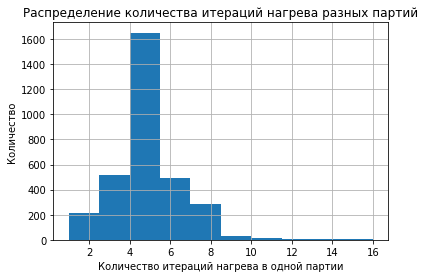

In [5]:
plt.figure()
ax = data_arc.groupby('key')['active_power'].count().hist()
ax.set_title('Распределение количества итераций нагрева разных партий')
ax.set_ylabel('Количество')
ax.set_xlabel('Количество итераций нагрева в одной партии')
plt.show()

Чаще всего в партии 5 итераций нагрева.

Теперь посмотрим гистограммы для мощностей - активной и реактивной.

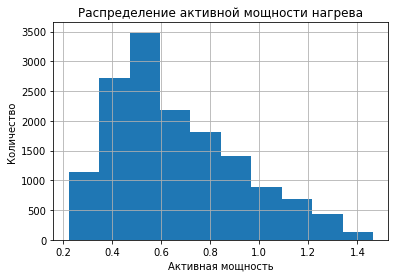

In [6]:
plt.figure()
ax = data_arc['active_power'].hist()
ax.set_title('Распределение активной мощности нагрева')
ax.set_ylabel('Количество')
ax.set_xlabel('Активная мощность')
plt.show()

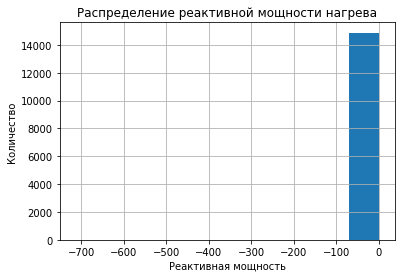

In [7]:
plt.figure()
ax = data_arc['reactive_power'].hist()
ax.set_title('Распределение реактивной мощности нагрева')
ax.set_ylabel('Количество')
ax.set_xlabel('Реактивная мощность')
plt.show()

Есть аномалия - отрицательное значение. Просмотрим 5 самых низких значений в реактивной мощности.

In [8]:
data_arc.sort_values(by = ['reactive_power']).head()

,key,start_time,end_time,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
709,152,2019-05-09 11:26:58,2019-05-09 11:29:41,0.228852,0.153777
3290,711,2019-05-31 07:16:01,2019-05-31 07:20:05,0.242989,0.153921
11794,2567,2019-08-13 05:51:16,2019-08-13 05:52:22,0.288314,0.155221
6130,1336,2019-06-22 15:46:26,2019-06-22 15:47:50,0.244191,0.156525


Отрицательное значение только одно. Скорее всего оно связано со сбоем в работе оборудования. Удалим его.

In [9]:
data_arc = data_arc.query('key != 2116')

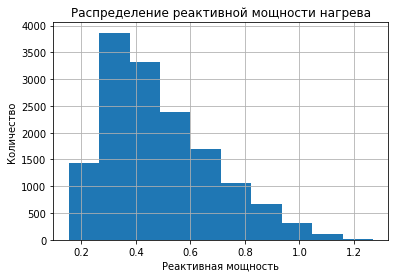

In [10]:
plt.figure()
ax = data_arc['reactive_power'].hist()
ax.set_title('Распределение реактивной мощности нагрева')
ax.set_ylabel('Количество')
ax.set_xlabel('Реактивная мощность')
plt.show()

Выброса больше нет. 

Далее составим сгруппированную по сумме таблицу по key.

In [11]:
data_arc_sum = pd.pivot_table(data_arc,
                             values=['active_power','reactive_power'],
                             index='key',
                             aggfunc={'active_power': np.sum,
                                      'reactive_power': np.sum})
data_arc_sum.columns = ['sum_active_power','sum_reactive_power']
data_arc_sum.head()

,sum_active_power,sum_reactive_power
key,,
1,3.036730,2.142821
2,2.139408,1.453357
3,4.063641,2.937457
4,2.706489,2.056992
5,2.252950,1.687991


Теперь посчитаем полную мощность по формуле корня квадратного из суммы квадратов активной и реактивной мощностей. Зафиксируем в итоговой таблице.

In [12]:
data_arc_sum.insert(loc=2, 
                    column='full_power', 
                    value=(data_arc_sum['sum_active_power']**2 + data_arc_sum['sum_reactive_power']**2)**0.5)
data_arc_full = data_arc_sum.drop(['sum_active_power', 'sum_reactive_power'], axis=1)
data_arc_full.head()

,full_power
key,
1,3.716640
2,2.586371
3,5.014163
4,3.399456
5,2.815155


In [13]:
data_arc_sum.describe()

,sum_active_power,sum_reactive_power,full_power
count,3213.000000,3213.000000,3213.000000
mean,3.067683,2.254693,3.808130
std,1.208719,0.894787,1.501367
min,0.267676,0.196228,0.331897
25%,2.236693,1.631855,2.775108
50%,2.984607,2.177210,3.693377
75%,3.775574,2.788381,4.692685
max,12.375636,8.949049,15.272257


Подготовим будущий дополнительный признак - общее время нагрева каждой партии.

In [14]:
data_arc['time_heat'] = data_arc['end_time'] - data_arc['start_time']
data_arc['time_heat'] = data_arc['time_heat'] / pd.Timedelta(seconds=1)
data_arc.head(5)

,key,start_time,end_time,active_power,reactive_power,time_heat
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0


In [15]:
data_arc_time_heat = pd.pivot_table(data_arc,
                             values=['time_heat'],
                             index='key',
                             aggfunc='sum')

data_arc_time_heat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 1 to 3241
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time_heat  3213 non-null   float64
dtypes: float64(1)
memory usage: 50.2 KB


### Данные о подаче сыпучих материалов 

In [16]:
data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')

In [17]:
display(data_bulk.head())
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [18]:
display(data_bulk.info())
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


В обеих таблицах много пропусков, это означает, что опеределенные материалы не добавлялись в той или иной партии. Определим материалы, которые использовались для менее 10% партий.

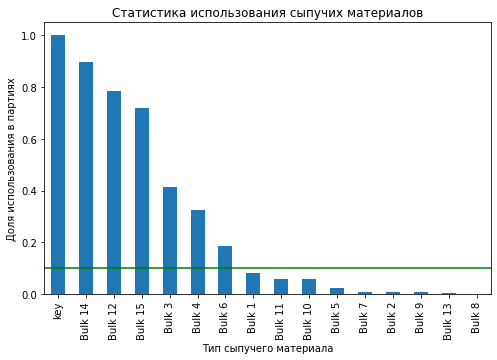

In [19]:
plt.figure(figsize = (8,5))
ax = (~data_bulk_time.isnull()).mean().sort_values(ascending=False).plot(kind = 'bar')
ax.axhline(y=0.1, color='g', linestyle='-')
ax.set_title('Статистика использования сыпучих материалов')
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Тип сыпучего материала')
plt.show()

На графике видно, что материалы 1, 11, 10, 5, 7, 2, 9, 13, 8 очень редко использовались. Убирать мы их не будем, но примем к сведению.

На следующем графике посмотрим - какой общий объем для каждой сыпучей добавки.

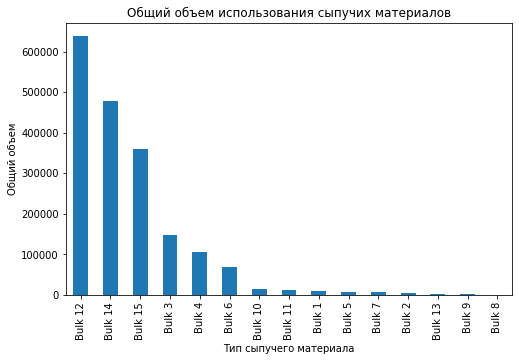

In [20]:
plt.figure(figsize = (8,5))
ax = data_bulk.drop(['key'], axis=1).sum().sort_values(ascending=False).plot(kind = 'bar')
ax.set_title('Общий объем использования сыпучих материалов')
ax.set_ylabel('Общий объем')
ax.set_xlabel('Тип сыпучего материала')
plt.show()

Распределение такое же как и на предыдущем графике - лидирующие позиции по использованию у добавок у 12,14,15,3,4 и 6.

### Данные о проволочных материалах

In [21]:
data_wire = pd.read_csv('/datasets/data_wire_new.csv')
data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

In [22]:
display(data_wire.head())
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Структура таблиц такая же как и у data_bulk и data_bulk_time. Выявим материалы, которые меньше всего использовались - менее 10%.

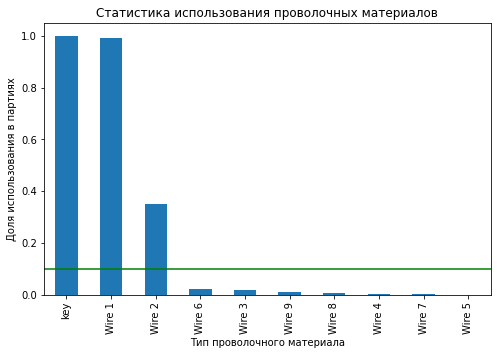

In [23]:
plt.figure(figsize = (8,5))
ax = (~data_wire_time.isnull()).mean().sort_values(ascending=False).plot(kind = 'bar')
ax.axhline(y=0.1, color='g', linestyle='-')
ax.set_title('Статистика использования проволочных материалов')
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Тип проволочного материала')
plt.show()

БОльшая часть проволочных материалов использовалась очень редко. Это материалы 6, 3, 9, 8, 4, 7, 5.

На следующем графике посмотрим - какой общий объем для каждой проволочной добавки.

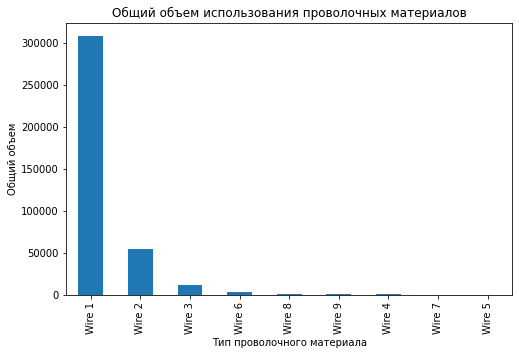

In [24]:
plt.figure(figsize = (8,5))
ax = data_wire.drop(['key'], axis=1).sum().sort_values(ascending=False).plot(kind = 'bar')
ax.set_title('Общий объем использования проволочных материалов')
ax.set_ylabel('Общий объем')
ax.set_xlabel('Тип проволочного материала')
plt.show()

Здесь также лидируют добавки 1 и 2.

### Данные о продувке сплава газом

In [25]:
data_gas = pd.read_csv('/datasets/data_gas_new.csv')

display(data_gas.head())
data_gas.info()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [26]:
data_gas.columns = ['key','gas']

In [27]:
data_gas['gas'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas, dtype: float64

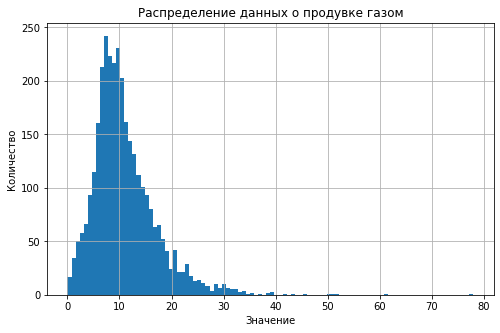

In [28]:
plt.figure(figsize = (8,5))
ax = data_gas['gas'].hist(bins=100)
ax.set_title('Распределение данных о продувке газом')
ax.set_ylabel('Количество')
ax.set_xlabel('Значение')
plt.show()

На каждую партию была одна продувка. Пропусков нет. Есть очень высокие отдельные показатели, когда требовалось очень много газа для продувки. Посмотрим с чем это связано - отберем ключи партий, для которых требовалась продувка выше 40. Далее проверим какие материалы подавались в эту партию.

In [29]:
gas_keys=data_gas['key'][data_gas['gas'] >= 40]
gas_keys

116      117
277      280
319      322
660      663
1461    1464
2105    2108
2107    2110
2567    2570
Name: key, dtype: int64

In [30]:
data_bulk.query('key in @gas_keys')

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
104,117,52.0,325.0,NaN,68.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262,280,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,63.0,NaN,NaN,108.0,NaN,263.0,NaN
303,322,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,NaN,1849.0,NaN,636.0,NaN
632,663,27.0,NaN,100.0,127.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,413.0,NaN,299.0,204.0
1410,1464,31.0,NaN,NaN,105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,774.0,NaN,306.0,100.0
2036,2108,63.0,242.0,NaN,98.0,94.0,NaN,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2038,2110,39.0,270.0,NaN,94.0,122.0,NaN,405.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2478,2570,50.0,270.0,NaN,124.0,18.0,NaN,352.0,NaN,NaN,NaN,NaN,108.0,NaN,NaN,NaN


In [31]:
data_wire.query('key in @gas_keys')

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
101,117,NaN,NaN,93.068977,NaN,NaN,26.975523,NaN,NaN,NaN
257,280,160.174557,76.236166,NaN,NaN,NaN,NaN,NaN,46.002319,NaN
299,322,NaN,188.228550,NaN,NaN,NaN,NaN,NaN,NaN,NaN
627,663,130.244400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1392,1464,280.987214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,2108,11.051040,NaN,93.213127,92.570401,NaN,63.045845,1.053936,NaN,NaN
2012,2110,3.101280,NaN,93.165077,56.078880,NaN,91.428487,0.234208,NaN,NaN
2443,2570,32.279522,NaN,NaN,NaN,NaN,44.307125,9.017009,NaN,NaN


Во все эти партии подавались редкие сыпучие материалы - которые, использовались менее чем в 10% партий.

Касательно проволочных материалов - здесь только в 5 из 8 партий подавались редкие материалы.

Посмотрим теперь на мощности.

In [32]:
data_arc_sum.query('key in @gas_keys')

,sum_active_power,sum_reactive_power,full_power
key,,,
117,4.191196,2.908158,5.101324
280,4.248512,2.967820,5.182452
322,8.914806,6.564143,11.070761
663,4.318215,3.038392,5.280039
1464,1.604796,1.195681,2.001255
2108,10.706804,7.589489,13.123871
2110,1.945132,1.446366,2.423946
2570,5.330177,3.890786,6.599167


Почти во всех партиях, кроме двух 1464 и 2110, активная и реактивная мощность больше третьего квартиля 3.8 и 2.8 соответственно.

Сделаем предположение, что для партий с большой продувкой газом было подано больше материалов, а соответственно было затрачено больше мощности на её нагрев.

Посмотрим количество итераций для партий с такой большой продувкой.

In [33]:
data_arc.query('key in @gas_keys').groupby(['key']).agg('count')

,start_time,end_time,active_power,reactive_power,time_heat
key,,,,,
117,6,6,6,6,6
280,9,9,9,9,9
322,13,13,13,13,13
663,8,8,8,8,8
1464,4,4,4,4,4
2108,16,16,16,16,16
2110,5,5,5,5,5
2570,9,9,9,9,9


Учитывая, что в среднем количество итераций для партии 5, здесь никакой закономерности не выявлено.

### Результаты измерения температуры

In [34]:
data_temp = pd.read_csv('/datasets/data_temp_new.csv')

display(data_temp.head())
data_temp.info()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


В этой таблице наш целевой признак. Здесь есть пропуски, нужно изменить формат времени и переименовать столбцы.

In [35]:
data_temp.columns = ['key', 'datetime', 'temp']
data_temp['datetime'] = pd.to_datetime(data_temp['datetime'])

data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   key       18092 non-null  int64         
 1   datetime  18092 non-null  datetime64[ns]
 2   temp      14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [36]:
len(data_temp['key'].unique())

3216

In [37]:
data_temp['temp'].describe()

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: temp, dtype: float64

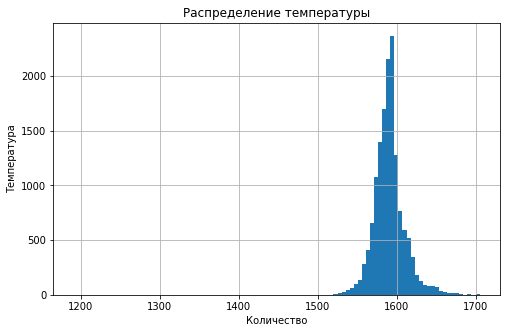

In [38]:
plt.figure(figsize = (8,5))
ax = data_temp['temp'].hist(bins=100)
ax.set_title('Распределение температуры')
ax.set_ylabel('Температура')
ax.set_xlabel('Количество')
plt.show()

Известно, что температура стали не может быть менее 1500. Значит партии с таким показателем нужно удалить целиком.

In [39]:
data_temp.query('temp < 1500')

,key,datetime,temp
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


In [40]:
del_keys = [867, 1214, 1619, 2052, 2561]
data_temp = data_temp.query('key not in @del_keys')
data_temp.query('temp < 1500')

,key,datetime,temp


Теперь удалим партии с одним замером температуры.

In [41]:
count_temp= data_temp.groupby('key')['temp'].count()
del_count_temp = count_temp[count_temp==1]
del_keys = del_count_temp.index.values.tolist()
len(del_keys)

740

In [42]:
data_temp_clear = data_temp.query('key not in @del_keys')

In [43]:
count_temp= data_temp_clear.groupby('key')['temp'].count()

In [44]:
count_temp[count_temp==1].sum()

0

Составим сводную таблицу со значениями времени первого и последнего замера.

In [45]:
data_temp_start_temp = data_temp_clear.groupby('key').first()

data_temp_end_temp = data_temp_clear.groupby('key').last()

data_temp_final = data_temp_start_temp.merge(data_temp_end_temp, on='key')
data_temp_final.columns = ['start_time', 'start_temp', 'end_time', 'end_temp']
data_temp_final = data_temp_final[['start_temp', 'end_temp']]
display(data_temp_final.head())
data_temp_final.info()

,start_temp,end_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   start_temp  2471 non-null   float64
 1   end_temp    2471 non-null   float64
dtypes: float64(2)
memory usage: 57.9 KB


Наша цель предсказать значение столбца end_temp. Перейдем к подготовке финальной таблицы.

## Подготовка финальной таблицы с признаками <a id='final'></a>

На этом этапе мы будем объединять данные из таблиц data_arc_sum, data_temp_final, data_bulk, data_gas и data_wire. В каждой таблице преобразуем index в значение столбца key.

In [46]:
data_bulk = data_bulk.set_index('key')
data_bulk.columns = [f'bulk_{x}' for x in range(1,16)]
data_gas = data_gas.set_index('key')
data_gas.columns = ['gas']
data_wire = data_wire.set_index('key')
data_wire.columns = [f'wire_{x}' for x in range(1,10)]

Заменим пропуски нулем. Проведем замену типов данных в столбцах start_temp, end_temp и bulk на целые числа. Это сократит использование памяти и ускорит работу.

In [47]:
df = data_arc_full.merge(data_temp_final, on='key', how='inner')
df = df.merge(data_bulk, on='key', how='inner')
df = df.merge(data_gas, on='key', how='inner')
df = df.merge(data_wire, on='key', how='inner')

df = df.dropna(subset=['start_temp', 'end_temp'])
df = df.fillna(0)

df['start_temp'] = pd.to_numeric(df['start_temp'], downcast='integer')
df['end_temp'] = pd.to_numeric(df['end_temp'], downcast='integer')
for i in range(1,16):
    df[f'bulk_{i}'] = pd.to_numeric(df[f'bulk_{i}'], downcast='integer')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   full_power  2324 non-null   float64
 1   start_temp  2324 non-null   int16  
 2   end_temp    2324 non-null   int16  
 3   bulk_1      2324 non-null   int16  
 4   bulk_2      2324 non-null   int16  
 5   bulk_3      2324 non-null   int16  
 6   bulk_4      2324 non-null   int16  
 7   bulk_5      2324 non-null   int16  
 8   bulk_6      2324 non-null   int16  
 9   bulk_7      2324 non-null   int16  
 10  bulk_8      2324 non-null   int8   
 11  bulk_9      2324 non-null   int16  
 12  bulk_10     2324 non-null   int16  
 13  bulk_11     2324 non-null   int16  
 14  bulk_12     2324 non-null   int16  
 15  bulk_13     2324 non-null   int16  
 16  bulk_14     2324 non-null   int16  
 17  bulk_15     2324 non-null   int16  
 18  gas         2324 non-null   float64
 19  wire_1      2324 non-null  

Теперь проверим мультиколлинеарность, выясним есть ли сильные зависимости целевого признака от других признаков. Построим тепловую карту.

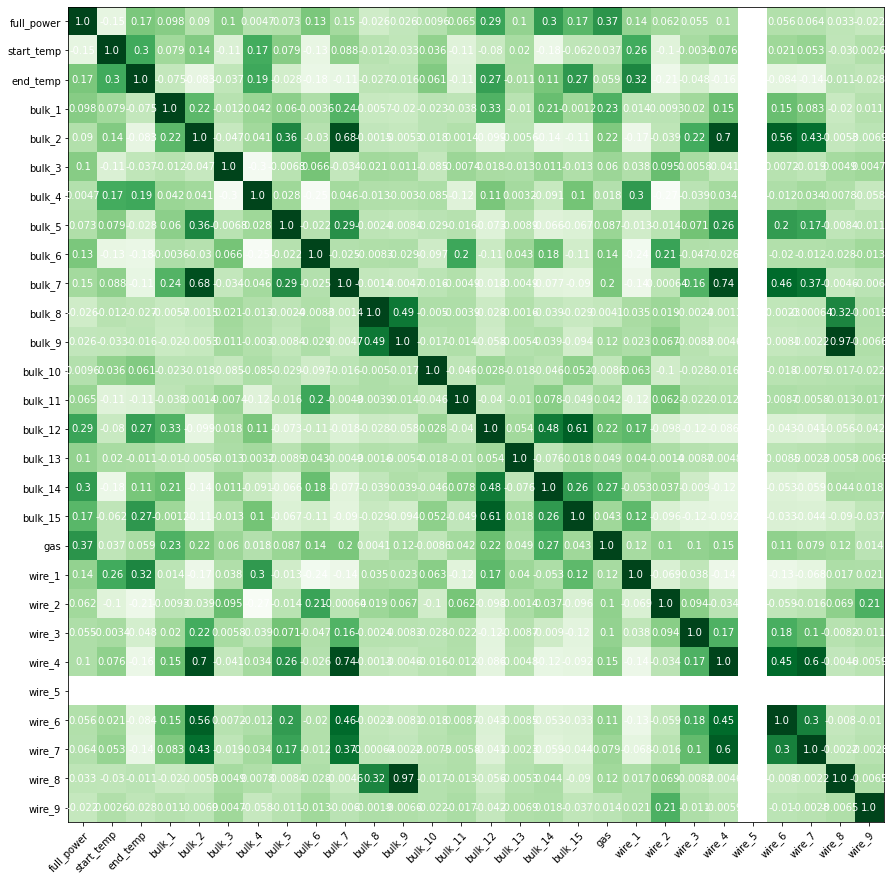

In [48]:
df_mult = df.copy()
corr_heatmap_df = df_mult.corr()

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks(np.arange(len(corr_heatmap_df.index)))
ax.set_yticks(np.arange(len(corr_heatmap_df.index)))

ax.set_xticklabels(corr_heatmap_df.index)
ax.set_yticklabels(corr_heatmap_df.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

data = corr_heatmap_df.values

for i in range(len(corr_heatmap_df.index)):
    for j in range(len(corr_heatmap_df.index)):
        text = ax.text(j, i, '{:.2}'.format(data[i, j]),
                       ha="center", va="center", color="w")
        
im = ax.imshow(corr_heatmap_df.corr(), cmap='Greens')

По карте видно, что есть сильная прямопропорциональная зависимость между bulk_9 и wire_8. Для простых моделей это может стать проблемой, поэтому для обучения будем использовать линейную модель с регуляризацией.

Добавим столбцы с дополнительными признаками:
- суммарный объем сыпучей/проволочной добавки для каждой партии
- кол-во итераций нагрева дугой
- кол-во замеров температуры
- суммарное время нагрева

In [49]:
#суммарный объем сыпучей/проволочной добавки для каждой партии
df['bulk_sum'] = df[['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 
                     'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 
                     'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']].sum(axis=1)
df['wire_sum'] = df[['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']].sum(axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   full_power  2324 non-null   float64
 1   start_temp  2324 non-null   int16  
 2   end_temp    2324 non-null   int16  
 3   bulk_1      2324 non-null   int16  
 4   bulk_2      2324 non-null   int16  
 5   bulk_3      2324 non-null   int16  
 6   bulk_4      2324 non-null   int16  
 7   bulk_5      2324 non-null   int16  
 8   bulk_6      2324 non-null   int16  
 9   bulk_7      2324 non-null   int16  
 10  bulk_8      2324 non-null   int8   
 11  bulk_9      2324 non-null   int16  
 12  bulk_10     2324 non-null   int16  
 13  bulk_11     2324 non-null   int16  
 14  bulk_12     2324 non-null   int16  
 15  bulk_13     2324 non-null   int16  
 16  bulk_14     2324 non-null   int16  
 17  bulk_15     2324 non-null   int16  
 18  gas         2324 non-null   float64
 19  wire_1      2324 non-null  

In [50]:
#кол-во итераций нагрева дугой
count_iter = data_arc.groupby('key')['active_power'].count()
df = df.merge(count_iter, on='key')
df = df.rename(columns={'active_power': 'count_iter'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   full_power  2324 non-null   float64
 1   start_temp  2324 non-null   int16  
 2   end_temp    2324 non-null   int16  
 3   bulk_1      2324 non-null   int16  
 4   bulk_2      2324 non-null   int16  
 5   bulk_3      2324 non-null   int16  
 6   bulk_4      2324 non-null   int16  
 7   bulk_5      2324 non-null   int16  
 8   bulk_6      2324 non-null   int16  
 9   bulk_7      2324 non-null   int16  
 10  bulk_8      2324 non-null   int8   
 11  bulk_9      2324 non-null   int16  
 12  bulk_10     2324 non-null   int16  
 13  bulk_11     2324 non-null   int16  
 14  bulk_12     2324 non-null   int16  
 15  bulk_13     2324 non-null   int16  
 16  bulk_14     2324 non-null   int16  
 17  bulk_15     2324 non-null   int16  
 18  gas         2324 non-null   float64
 19  wire_1      2324 non-null  

In [51]:
#кол-во замеров температуры
df = df.merge(count_temp, on='key', how='left')
df = df.rename(columns={'temp': 'count_temp'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   full_power  2324 non-null   float64
 1   start_temp  2324 non-null   int16  
 2   end_temp    2324 non-null   int16  
 3   bulk_1      2324 non-null   int16  
 4   bulk_2      2324 non-null   int16  
 5   bulk_3      2324 non-null   int16  
 6   bulk_4      2324 non-null   int16  
 7   bulk_5      2324 non-null   int16  
 8   bulk_6      2324 non-null   int16  
 9   bulk_7      2324 non-null   int16  
 10  bulk_8      2324 non-null   int8   
 11  bulk_9      2324 non-null   int16  
 12  bulk_10     2324 non-null   int16  
 13  bulk_11     2324 non-null   int16  
 14  bulk_12     2324 non-null   int16  
 15  bulk_13     2324 non-null   int16  
 16  bulk_14     2324 non-null   int16  
 17  bulk_15     2324 non-null   int16  
 18  gas         2324 non-null   float64
 19  wire_1      2324 non-null  

In [52]:
#суммарное время нагрева
df = df.merge(data_arc_time_heat, on='key', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   full_power  2324 non-null   float64
 1   start_temp  2324 non-null   int16  
 2   end_temp    2324 non-null   int16  
 3   bulk_1      2324 non-null   int16  
 4   bulk_2      2324 non-null   int16  
 5   bulk_3      2324 non-null   int16  
 6   bulk_4      2324 non-null   int16  
 7   bulk_5      2324 non-null   int16  
 8   bulk_6      2324 non-null   int16  
 9   bulk_7      2324 non-null   int16  
 10  bulk_8      2324 non-null   int8   
 11  bulk_9      2324 non-null   int16  
 12  bulk_10     2324 non-null   int16  
 13  bulk_11     2324 non-null   int16  
 14  bulk_12     2324 non-null   int16  
 15  bulk_13     2324 non-null   int16  
 16  bulk_14     2324 non-null   int16  
 17  bulk_15     2324 non-null   int16  
 18  gas         2324 non-null   float64
 19  wire_1      2324 non-null  

## Выбор моделей регрессии <a id='model'></a>

Выберем модели:
- RandomForestRegressor
- CatBoostRegressor
- LGBMRegressor

Разобьем данные на тренировочную и тестовую выборки. Выберем количество кросс-валидаций равным 5.

In [53]:
random_state=80823

features = df.drop('end_temp', axis=1)
target = df['end_temp']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=random_state)

cv_counts = 5

In [54]:
scaler= StandardScaler()
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

### Константная модель DummyRegressor

Для того, чтобы выявить адекватность наших моделей, рассмотрим результаты константной модели.

In [55]:
model_dummy = DummyRegressor(strategy='median')

model_dummy.fit(features_train_scaled, target_train)
predictions_dummy = model_dummy.predict(features_test_scaled)

print('MAE константной модели {:.2f}'.format(mean_absolute_error(target_test, predictions_dummy)))

MAE константной модели 8.24


### RandomForestRegressor

In [56]:
%%time

rfr=RandomForestRegressor(random_state=random_state)

param_grid = { 
    'n_estimators': [200, 300, 500, 700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,8,10,13,15]
}

CV_rfr = ms.GridSearchCV(estimator=rfr, 
                         param_grid=param_grid,
                         scoring='neg_mean_absolute_error',  
                         cv= cv_counts,
                         n_jobs = -1 
                        )
CV_rfr.fit(features_train_scaled, target_train)

CV_MAE_rfr = -CV_rfr.best_score_

print("Наилучшие параметры: ",CV_rfr.best_params_)
print("Наилучшая MAE: ",(CV_MAE_rfr))

Наилучшие параметры:  {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 500}
Наилучшая MAE:  6.202271416487327
CPU times: user 12min 8s, sys: 3.79 s, total: 12min 12s
Wall time: 12min 20s


### CatBoostRegressor

In [57]:
%%time

cbr = CatBoostRegressor(verbose=False, random_state=random_state)

param_grid = {
    'depth': [4, 6, 8],
    'n_estimators': [300, 500, 600],
    'l2_leaf_reg': [1, 3, 5],
    'learning_rate': [0.02, 0.03, 0.04]
}

CV_cbr = ms.GridSearchCV(estimator=cbr, 
                         param_grid=param_grid,
                         scoring='neg_mean_absolute_error',  
                         cv= cv_counts,
                         n_jobs = -1 
                        )
CV_cbr.fit(features_train_scaled, target_train)

CV_MAE_cbr = -CV_cbr.best_score_

print("Наилучшие параметры: ",CV_cbr.best_params_)
print("Наилучшая MAE: ",(CV_MAE_cbr))

Наилучшие параметры:  {'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'n_estimators': 600}
Наилучшая MAE:  5.989445273200926
CPU times: user 25min 7s, sys: 26.5 s, total: 25min 33s
Wall time: 32min 48s


In [64]:
best_params_cbr = CatBoostRegressor(verbose=False, 
                                    random_state=random_state).fit(features_train_scaled, 
                                                                   target_train).get_all_params()

### LGBMRegressor

In [66]:
%%time

lgbm = LGBMRegressor(random_state=random_state) 
param_grid = {
    'num_leaves': [5, 11],
    'learning_rate': [0.1, 0.05]
}

CV_lgbm = ms.GridSearchCV(estimator=lgbm, 
                         param_grid=param_grid,
                         scoring='neg_mean_absolute_error',  
                         cv= cv_counts,
                         n_jobs = -1 
                        )
CV_lgbm.fit(features_train_scaled, target_train)

CV_MAE_lgbm = -CV_lgbm.best_score_

print("Наилучшие параметры: ",CV_lgbm.best_params_)
print("Наилучшая MAE: ",(CV_MAE_lgbm))

Наилучшие параметры:  {'learning_rate': 0.05, 'num_leaves': 11}
Наилучшая MAE:  6.142915644029731
CPU times: user 33min 26s, sys: 20.2 s, total: 33min 46s
Wall time: 33min 57s


In [67]:
index = ['RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']
data = {'MAE TRAIN':[CV_MAE_rfr,
                     CV_MAE_cbr,
                     CV_MAE_lgbm]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение задачи'] = scores_data['MAE TRAIN'] <= 6.8

scores_data

,MAE TRAIN,Выполнение задачи
RandomForestRegressor,6.202271,True
CatBoostRegressor,5.989445,True
LGBMRegressor,6.142916,True


По итогам обучения все модели оказались адекватными - их МАЕ было ниже 8.24 (DummyRegressor). Также все модели прошли порог в 6.8 установленный заказчиком. Лучший результат показала модель CatBoostRegressor с параметрами {'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'n_estimators': 600}. Её мы проверим на тестовом наборе данных.

## Проверка выбранной модели на тестовом наборе данных <a id='test'></a>

In [65]:
%%time

model = CatBoostRegressor(verbose=False)
model.set_params(**best_params_cbr)
model.fit(features_train_scaled, target_train)
target_predict = model.predict(features_test_scaled)
test_MAE_cbr = mean_absolute_error(target_predict, target_test)

print('Значение метрики MAE модели CatBoostRegressor на тестовой метрике', test_MAE_cbr)

Значение метрики MAE модели CatBoostRegressor на тестовой метрике 6.369940830289071
CPU times: user 6.44 s, sys: 133 ms, total: 6.57 s
Wall time: 7.66 s


**ВЫВОД:** Итак, модель CatBoostRegressor с гиперпараметрами {'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'n_estimators': 600} на тестовой выборке показала МАЕ 6.4. Что удовлетворяет условиям заказчика.

## Составление итогового отчета <a id='conclusion'></a>

Набор данных для этого проекта был предоставлен заказчиком. Он состоит из 7 таблиц:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Таблицы содержат информацию о полном процессе изготовления более 3000 партий стали. Наша задача состоит в том, чтобы обучить модель **предсказанию конечной температуры стали**. Это поможет заказчику сократить затраты на электроэнергию.

Для оценки эффективности нашей модели был выбран показатель МАЕ - среднее абсолютное отклонение. Он покажет на сколько градусов в среднем может ошибаться наша модель. Показатель **МАЕ < 6.8** будет считаться приемлемым.

В начале нашей работы мы подробно изучили каждую таблицу и внесли некоторые изменения:

- В таблице с **данными об электродах** мы убрали аномальное (отрицательное) значение в столбце реактивной мощности - удалили всю партию. Затем мы сформировали один из новых признаков - полную мощность для производства каждой партии и общее время нагрева каждой партии.
- В таблицах с **данными о объемах подачи сыпучих и проволочных материалов** мы вяснили, что далеко не все материалы были использованы - поэтому в этих таблицах много пропусков. Самыми часто встречающимися добавками оказались - bulk_12 и wire_1.
- В таблице с **данными о продувке газом** выявили, что наибольшие показатели в этой таблице характерны для партий с большим объемом добавок, а следовательно наибольшей затраченной мощностью. Зависимости между кол-во итераций нагрева и большим показателем продува не выявлено.
- В таблице с **данными об измерениях температуры** мы сначала удалили партии, в которых были температуры ниже 1500 градусов. Затем мы убрали партии, где был только один замер температуры. Далее мы составили сводную таблицу с начальной и конечной температурой для каждой партии.

Следующим шагом мы приступили к созданию общей таблицы с **целевым признаком** - конечной температуры партии - и остальными **признаками** для каждой партии. Это:

- начальная температура
- суммарный объем добавленного сыпучего материала
- суммарный объем добавленного проволочного материала
- полная мощность
- общее время нагрева партии
- количество замеров температуры
- количество итераций нагрева дугой

В итоговую таблицу были добавлены только те партии, данные о которых были во всех таблицах.

Далее мы приступили к подготовке таблицы для обучения. Отделили **25% данных для тестовой** выборки. Признаки стандартизировали с использованием стандартной функции `Scaler()`.

Для проверки наших моделей на адекватность мы обучили константную модель **DummyRegressor**, которая предсказывала медианное значение. Мы получили показатель **МАЕ = 8.24**. Если наша модель будет показывать МАЕ меньше этой цифры, то мы продолжим с ней дальнейшую работу.

Были выбраны следующие модели: **RandomForestRegressor**, **CatBoostRegressor** и **LGBMRegressor**.

Для каждой модели мы подобрали гиперпараметры с использованием `GridSearchCV()` и получили следующие показатели МАЕ на обучающией выборке:

| **Модель**               | **МАЕ TRAIN** | 
|--------------------------|---------------|
| RandomForestRegressor    | 6.2           |
| CatBoostRegressor        | 6.0           |
| LGBMRegressor            | 6.1           |

Все модели показали адекватную работу по сравнению с константной моделью. По полученным результатам была выбрана модель **CatBoostRegressor** со следующими гиперпараметрами `{'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'n_estimators': 600}`. Она показала метрику **МАЕ=5.9**.

В конце исследования мы провели проверку нашей модели на тестовой выборке и получили значение **МАЕ=6.4**. Эта цифра означает, что наша модель соответсвует требованию заказчика и модель **может ошибаться в среднем на +/- 6 градусов**.